## Outline
1. Prepare the data
2. Build the model
3. Train the model
4. Analyze the model's results

In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from typing import Any, Callable, Optional, Sequence

torch.set_printoptions(precision=2, linewidth=120) #https://pytorch.org/docs/stable/generated/torch.set_printoptions.html

### Prepare the data

First, we load the MNIST dataset using the `torchvision.datasets.MNIST` class [[source](https://pytorch.org/docs/stable/_modules/torchvision/datasets/mnist.html#MNIST)]. This class has the following parameters:

* `root (str)`: the path to the directory in which the dataset is present or in which it will be downloaded in case it is not present
* `train (bool)`: if True, the training dataset of MNIST is considered, otherwise the test dataset
* `download (bool)`: if True, the dataset is downloaded in case it is not present in the root directory
* `transform (callable)`: function/transform which takes an image as input and apply some transformations

The `transforms.Compose` class allow us to use several transforms together [[source](https://pytorch.org/docs/stable/torchvision/transforms.html)]. For the particular case, we are just converting the input image into a `torch.Tensor` and using the `transforms.Normalize` to normalize each image based on the mean and on the standard deviation of the MNIST training set: the values 0.1307 and 0.3081 are the precomputed mean and std [[discussion](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457)].

---

#### TODO
* Dataset class
* Split into training and validation sets


In [2]:
train_set = torchvision.datasets.MNIST(
                          root='./data/'
                        , train=True
                        , download=True
                        , transform=transforms.Compose([
                              transforms.ToTensor()
                            , transforms.Normalize((0.1307,), (0.3081,))
                            ])
                        )   


test_set = torchvision.datasets.MNIST(
                          root='./data/'
                        , train=False
                        , download=False
                        , transform=transforms.Compose([
                              transforms.ToTensor()
                            , transforms.Normalize((0.1307,), (0.3081,))
                            ])
                        )

While the `torchvision.datasets.MNIST` class (which is a subclass of the `torch.utils.data.Dataset`) is useful to represent the MNIST dataset, the `torch.utils.data.DataLoader` [[source](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader)] helps us to have a better access to the underlying data. In particular, the `MNIST` class provides two methods (`__getitem__()` and `__len__()`) that are exploited by the `DataLoader` in order to offer us an easier access to the data. The `DataLoader` takes several parameters:

* `dataset (torch.utils.data.Dataset)`: the dataset to be handled
* `batch_size (int)`: the size of each batch
* `shuffle (bool)`: if True, the dataset will be shuffled
* `num_workers (int)`: number of processes (useful in case of large datasets) 


## TODO
SubsetRandomSampler https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

In [3]:
train_loader = torch.utils.data.DataLoader(
                              dataset=train_set
                            , batch_size=5
                            , shuffle=True
                            )

test_loader = torch.utils.data.DataLoader(
                              dataset=test_set
                            , batch_size=10
                            , shuffle=False
                            )

At this point, we can analyze the dataset.

In [4]:
def mnist_statistics(
      dataset: torchvision.datasets
    , train: Optional[bool]=True
    ) -> None:
    """Function that prints some basic statistics of the MNIST dataset.
    
    Args:
        dataset (torchvision.datasets): training or test set of MNIST dataset
        train (bool): if True the train set statistics are printed, else the test set ones
    """

    if train: print("*** TRAIN ***")
    else: print("*** TEST ***")
    print("N. samples:    \t{0}".format(len(dataset)))
    print("Targets:       \t{0}".format(set(dataset.targets.numpy())))
    print("Target distr.: \t{0}".format(dataset.targets.bincount()/len(dataset)*100))
    image, label = next(iter(dataset))
    print("Data type:     \t{0}".format(type(image)))
    print("Data shape:    \t{0}".format(image.shape))
    print("Label type:    \t{0}".format(type(label)))


def show_data(dataset: torchvision.datasets) -> None:
    '''
    Function that shows the first 20 images of MNIST training set.
    
    Args:
        dataset (torchvision.datasets): training set of MNIST dataset
    '''
    
    plt.figure(figsize=(50,50))
    for i, sample in enumerate(dataset, start=1):
        image, label = sample
        plt.subplot(10, 10, i)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(dataset.classes[label], fontsize=28)
        if (i >= 20): break
    plt.show()

*** TRAIN ***
N. samples:    	60000
Targets:       	{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Target distr.: 	tensor([ 9.87, 11.24,  9.93, 10.22,  9.74,  9.03,  9.86, 10.44,  9.75,  9.91])
Data type:     	<class 'torch.Tensor'>
Data shape:    	torch.Size([1, 28, 28])
Label type:    	<class 'int'>
*** TEST ***
N. samples:    	10000
Targets:       	{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Target distr.: 	tensor([ 9.80, 11.35, 10.32, 10.10,  9.82,  8.92,  9.58, 10.28,  9.74, 10.09])
Data type:     	<class 'torch.Tensor'>
Data shape:    	torch.Size([1, 28, 28])
Label type:    	<class 'int'>


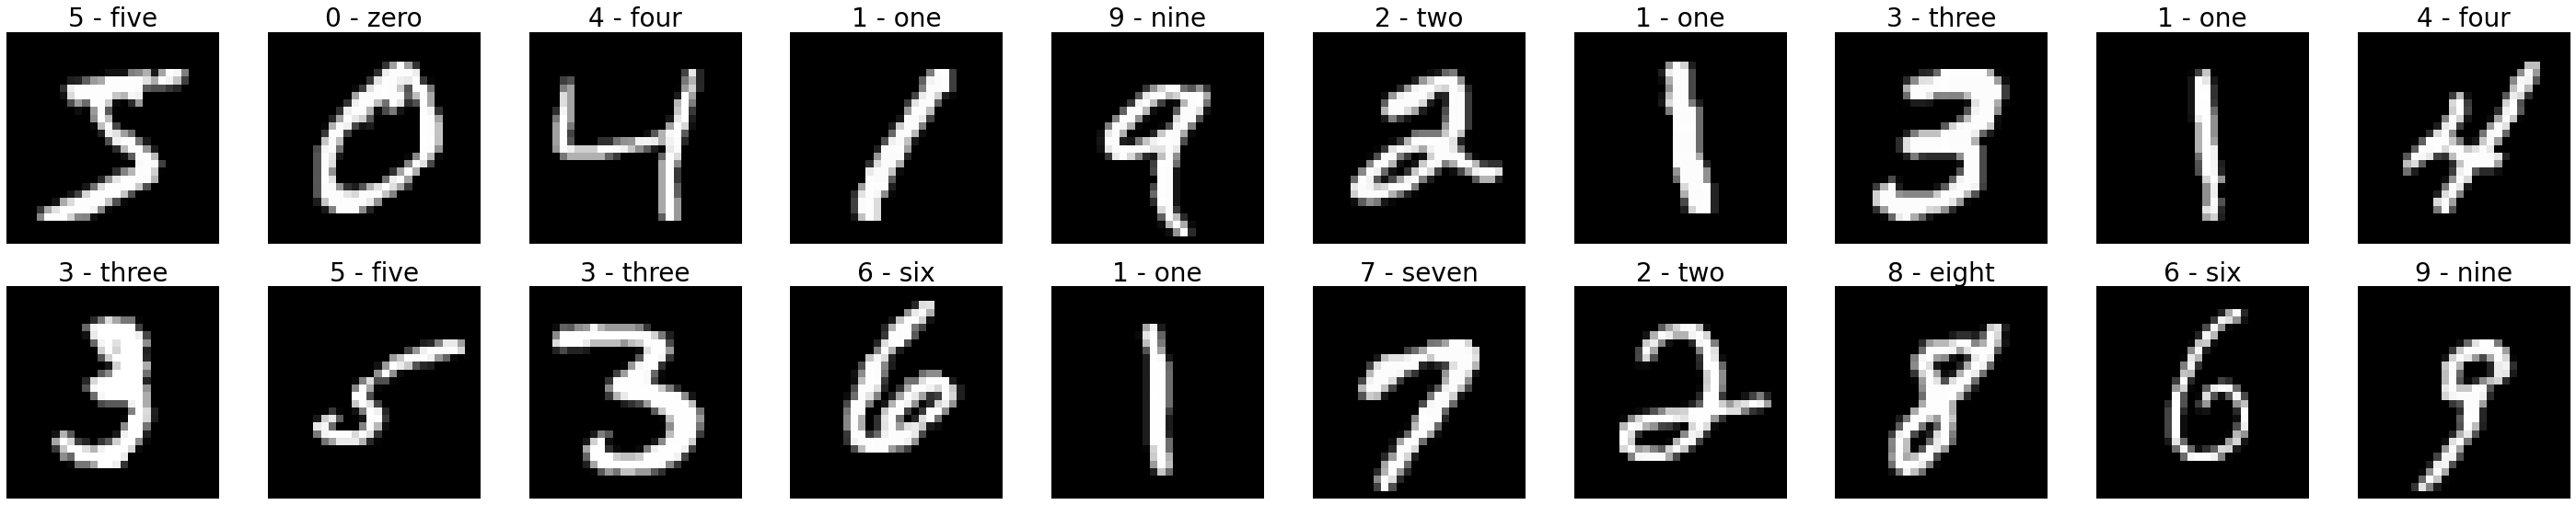

In [5]:
mnist_statistics(dataset=train_set, train=True)
mnist_statistics(dataset=test_set, train=False)
show_data(dataset=train_set)

As we can see the MNIST dataset is composed by 60'000 samples (training set) and 10'000 samples (test set). Each element (that we can access via the `DataLoader` class) is a tuple containing the data (`<class 'torch.Tensor'>` of shape `torch.Size([1, 28, 28])`) and the associated label (`int`).

Another important aspect to take into consideration is the fact that the `MNIST` is an _unbalanced dataset_. Looking at the target distribution we can notice that less samples are available for class `5` (9.03%) while class `1` is the more populated one (11.24%). A possibile solution might be the one of considering a Cross-Entropy loss with weights [[source](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=loss#torch.nn.CrossEntropyLoss)]

### Build the model

In order to build our CNN model, we procede as follows:
* we create a `CNN` class that will handle our Convolutional Neural Network
* we define the network architecture in the `__init__()` using the `nn.Sequential` module and some pre-built layers provided by `torc.nn`
* we define the forward phase of the network exploiting some "_home-made_" functions

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import re   # regular expressions

In [7]:
class CNN(nn.Module):

    num_outputs: int
    name: str
    device: str
    net: nn.Sequential


    def __init__(
          self
        , model: Optional[str]='model1'
        , device: Optional[str]='cpu'
        ) -> None:
        """
        CNN class constructor.

        Args:
            model   (str): {'model1' (default), 'model2'} several models are provided for this example.
            device  (str): {'cpu}
        """

        super(CNN, self).__init__()

        self.num_outputs = 10       # for MNIST dataset: 10-class classification problem
        self.name = "CNN-{0}".format(model)

        # device setup
        if torch.cuda.is_available() and bool(re.findall("cuda:[\d]+$", device)): 
            self.device = torch.device(device)
        else:
            self.device = torch.device("cpu")


        if model == "model1":

            self.net = nn.Sequential(
                    # [batch_size, 1, 28, 28]
                    nn.Conv2d(
                          in_channels=1
                        , out_channels=12
                        , kernel_size=5
                        , stride=1
                        , padding=0
                    )
                    # [batch_size, 12, 24, 24]
                    , nn.ReLU(inplace=True)
                    # [batch_size, 12, 24, 24]
                    , nn.MaxPool2d(
                          kernel_size=2
                        , stride=2
                        , padding=0
                    )
                    # [batch_size, 12, 12, 12]
                    , nn.Conv2d(
                          in_channels=12
                        , out_channels=24
                        , kernel_size=5
                        , stride=1
                        , padding=0
                    )
                    # [batch_size, 24, 8, 8]
                    , nn.ReLU(inplace=True)
                    # [batch_size, 24, 8, 8]
                    , nn.MaxPool2d(
                          kernel_size=2
                        , stride=2
                        , padding=0
                    )
                    # [batch_size, 24, 4, 4]
                    , nn.Flatten()
                    # [batch_size, 384]
                    , nn.Linear(
                          in_features=4*4*24
                        , out_features=784
                    )
                    # [batch_size, 784]
                    , nn.ReLU(inplace=True)
                    # [batch_size, 784]
                    , nn.Dropout()
                    # [batch_size, 784]
                    , nn.Linear(
                          in_features=784
                        , out_features=10
                    )
                    # [batch_size, self.num_outputs]
            )

        else:
            raise ValueError('{0}: undefined model'.format(model))

        # moving network to the correct device memory
        self.net.to(self.device)


    def save(
          self
        , path: str
        ) -> None:
        """
        Save the classifier.
        All the useful parameters of the network are saved to memory.
        More info here: https://pytorch.org/tutorials/beginner/saving_loading_models.html
        
        Args:
            path   (str): path of the saved file, must have .pth extension
        """

        torch.save(self.net.state_dict(), path)


    def save_all(
          self
        , epoch: int
        , loss: torch.Tensor
        , path: str
        ) -> None:
        """
        Save the classifier and the other hyperparameters.
        All the useful parameters of the network are saved to memory, plus other informations
        such as the number of epochs and the optimizer parameters.
        More info here: https://pytorch.org/tutorials/beginner/saving_loading_models.html
        
        Args:
            epochs        (int): number of epochs computed till the current moment
            loss (torch.Tensor): loss of the network till the current moment
            path          (str): path of the saved file, must have .pth extension
        """

        torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss_state_dict': loss.state_dict()
                    }, path)


    def load(
          self
        , path: str
        ) -> None:
        """
        Load the classifier.
        All the useful parameters of the network are loaded from memory.
        More info here: https://pytorch.org/tutorials/beginner/saving_loading_models.html
        map-location indicates the location where all tensors should be loaded
        
        Args:
            path   (str): name of the saved file, must have .pth extension
        """

        self.net.load_state_dict(torch.load(path, map_location=self.device))
        self.net.to(self.device)


    def load_all(
          self
        , path: str
        ) -> Sequence[int, torch.Tensor]:
        """
        Load the classifier and the other hyperparameters.
        All the useful parameters of the network are loaded from memory, plus other informations
        such as the number of epochs and the optimizer parameters.
        More info here: https://pytorch.org/tutorials/beginner/saving_loading_models.html
        map-location indicates the location where all tensors should be loaded
        
        Args:
            path          (str): path of the saved file, must have .pth extension

        Returns:
            epochs        (int): number of epochs computed till the saved moment
            loss (torch.Tensor): loss of the network till the saved moment
        """

        checkpoint = torch.load(path)
        self.net.load_state_dict(checkpoint['model_state_dict'], map_location=self.device)
        self.net.to(self.device)
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location=self.device)
        self.optimizer.to(self.device)
        loss.load_state_dict(checkpoint['loss_state_dict'], map_location=self.device)
        loss.to(self.device)
        epoch = checkpoint['epoch']

        return epoch, loss


    def forward(
          self
        , x: torch.Tensor
        ) -> torch.Tensor:
        """
        Compute the output of the network.
        After the forward phase over the layers of the network we obtain the so called "logits",
        which (in this case) is a tensor of raw (non-normalized) predictions that the classification 
        model generates, and which is then passed to a normalization function (softmax).
        
        Args:
            x       (torch.Tensor): 4D input Tensor of the CNN [batch_size, 1, 28, 28] 
        
        Returns:
            outputs (torch.Tensor): 2D output Tensor of the net (after softmax act.) [batch_size, 10] 
            logits  (torch.Tensor): 2D output Tensor of the net (before softmax act.) [batch_size, 10]
        """

        logits = self.net(x)
        outputs = F.softmax(logits, dim=1)

        return outputs, logits  # logits returned to compute loss


    @staticmethod
    def decision(outputs: torch.Tensor) -> torch.Tensor:
        """
        Given the tensor with the net outputs, compute the final decision of the classifier (class label).
        The decision is the winning class, aka the class identified by the neuron with greatest value.

        Args:
            outputs     (torch.Tensor): 2D output Tensor of the net (after softmax act.) [batch_size, 10]

        Returns:
            decisions   (torch.Tensor): 1D output Tensor with the decided class IDs [batch_size].
        """

        # decision -> winning class
        decisions = torch.argmax(outputs, dim=1)

        return decisions


    @staticmethod
    def __loss(
          logits: torch.Tensor
        , labels: torch.Tensor
        , weights: Optional[torch.Tensor]=torch.Tensor([10.1300,  8.8994, 10.0705,  9.7863, 10.2705, 11.0681, 10.1386,  9.5770, 10.2547, 10.0857])
        ) -> torch.Tensor:
        """
        Compute the loss function of the cnn.

        Args:
            logits  (torch.Tensor): 2D output Tensor of the net (before softmax act.) [batch_size, 10]
            labels  (torch.Tensor): 1D labels Tensor of the samples in the mini-batch [batch_size]
            weights (torch.Tensor): 1D weight Tensor of the classes, usefull in unbalanced datasets. 
                                    For the MNIST dataset the weights are computed dividing the overall
                                    number of examples by the frequency of each class. The classes 
                                    having less samples will be weighted more wrt the ones with more samples

        Returns:
            tot_loss      (float): value of the loss function
        """
        tot_loss = F.cross_entropy(
                              input=logits
                            , target=labels
                            , weight=weights
                            , reduction='mean'
                            )
        return tot_loss


    def train_cnn(
          self
        , training_set: torch.utils.data.DataLoader
        , validation_set: torch.utils.data.DataLoader
        , batch_size: Optional[int]=64
        , optimizer_mode: Optional[str]="adam"
        , lr: Optional[float]=0.001
        , epochs: Optional[int]=10
        , momentum: Optional[float]=0.5
        ) -> None:
        """
        CNN training procedure.

        Args:
            trainin_set     (DataLoader): DataLoader of the training set
            validation_set  (DataLoader): DataLoader of the validation set
            batch_size             (int): number of samples for each mini-batch
            optimizer_mode         (str): {"adam", "sgd"}, type of optimizer
            lr                   (float): learning rate
            epochs                 (int): number of training epochs
        """
        
        best_validation_accuracy = -1.  # best accuracy on the validation data
        best_epoch = -1                 # epoch in which best accuracy was computed

        # set network in training mode (affect on dropout module)
        self.net.train()

        # optimizer https://pytorch.org/docs/stable/optim.html
        if optimizer_mode == "adam":
            self.optimizer = torch.optim.Adam(
                                  params=filter(lambda p:   # filter on parameters that require gradient
                                                    p.requires_grad, 
                                                    self.net.parameters()
                                                )
                                , lr=lr
                                )
            self.optimizer.to(self.device)

        elif optimizer_mode == "sgd":
            self.optimizer = torch.optim.SGD(
                                  params=filter(lambda p:   # filter on parameters that require gradient
                                                    p.requires_grad, 
                                                    self.net.parameters()
                                                )
                                , lr=lr
                                , momentum=momentum
                                )
            self.optimizer.to(self.device)

        else:
            raise ValueError("Invalid optimizer {}: \'adam\' or \'sgd\' must be provided")



        # start train phase (looping on epochs)
        # ----------------------
        for e in range(0, epochs):

            epoch_train_accuracy = 0.           # accuracy of current epoch over training set
            epoch_train_loss = 0.               # loss of current epoch over training set
            epoch_num_training_examples = 0     # accumulated number of training examples for current epoch

            # looping on batches
            # ----------------------
            for X, Y in training_set:
                
                # generally == batch_size, != in last batch if len(training_set) % batch_size != 0
                batch_num_training_examples = X.shape[0] 
                epoch_num_training_examples += batch_num_training_examples 

                # moving data to correct device (speed process up)
                X = X.to(self.device)
                Y = Y.to(self.device)

                # forwarding network
                outputs, logits = self.forward(X)

                # computing loss of network
                loss = CNN.__loss(logits, Y)

                # computing gradients and updating network weights
                optimizer.zero_grad()       # put all gradients to zero before computing backward phase
                loss.backward()             # computing gradients (for parameters with requires_grad=True)
                optimizer.step()            # updating parameters according to optimizer

                # learning phase computed, now we analyze the performances of the mini-batch
                with torch.no_grad():       # all the operations within this scope will be kept out of the autograd engine

                    self.net.eval()         # setting the network out of training mode (for dropout layer)

                    # evaluating performance of current mini-batch
                    batch_train_accuracy = self.__performance(outputs, Y)

                    # accumulating accuracy of all mini-batches for current epoch (batches normalized)
                    epoch_train_accuracy += batch_train_accuracy * batch_num_training_examples

                    # accumulating loss of all mini-batches for current epoch (batches normalized)
                    epoch_train_loss += loss.item() * batch_num_training_examples       # loss.item() to access value

                    # printing (mini-batch related) stats on screen
                    print("  mini-batch:\tloss={0:.4f}, tr_acc={1:.2f}".format(loss.item(), batch_train_accuracy))

                    # switching to train mode
                    self.net.train() 

            # ----------------------   
            # end of mini-batches scope

            # epoch scope
            # ----------------------

            # at the end of each epoch the network is evaluated on the validation set
            validation_accuracy = self.eval_cnn(validation_set)

            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                best_epoch = e + 1
                self.save_all(epoch=e, loss=loss, path="./models/CNN-{0}.pth".format(self.name))

            # epoch loss computation
            epoch_train_loss /= epoch_num_training_examples

            # printing (epoch related) stats on screen
            print(("epoch={0}/{1}:\tloss={2:.4f}, tr_acc={3:.2f}, val_acc={4:.2f}"
                   + (", BEST!" if best_epoch == e + 1 else ""))
                  .format(e + 1, epochs, epoch_train_loss,
                          epoch_train_acc / epoch_num_train_examples, val_acc))

In [8]:
classifier = CNN()

In [9]:
x1, y1 = next(iter(train_loader))

In [10]:
output, logits = classifier(x1)

In [11]:
output

tensor([[0.10, 0.09, 0.11, 0.11, 0.09, 0.08, 0.13, 0.08, 0.12, 0.09],
        [0.10, 0.10, 0.08, 0.12, 0.09, 0.11, 0.12, 0.08, 0.10, 0.10],
        [0.08, 0.09, 0.12, 0.10, 0.11, 0.09, 0.14, 0.09, 0.10, 0.09],
        [0.10, 0.08, 0.10, 0.11, 0.11, 0.09, 0.10, 0.09, 0.11, 0.11],
        [0.10, 0.10, 0.10, 0.11, 0.09, 0.10, 0.10, 0.09, 0.09, 0.13]], grad_fn=<SoftmaxBackward>)

In [12]:
logits

tensor([[-0.02, -0.11,  0.09,  0.14, -0.04, -0.14,  0.32, -0.16,  0.22, -0.12],
        [-0.08, -0.11, -0.35,  0.06, -0.16, -0.01,  0.04, -0.34, -0.09, -0.08],
        [-0.24, -0.17,  0.13,  0.01,  0.10, -0.14,  0.29, -0.07, -0.06, -0.13],
        [ 0.01, -0.20, -0.06,  0.10,  0.07, -0.13, -0.02, -0.07,  0.05,  0.04],
        [-0.08, -0.02, -0.02,  0.04, -0.15, -0.08, -0.06, -0.17, -0.13,  0.20]], grad_fn=<AddmmBackward>)

In [15]:
loss = CNN.myloss(logits, y1)

In [22]:
loss.item()

2.1671221256256104